# Exercise 2 - Generalized Linear Model

<hr style="height:2pt">

In this problem set, you will fit increasingly more complex Poisson GLMs to calcium imaging data. Specifically, you will learn to
- Fit Poisson GLMs on calcium imaging data 
- Select an optimal regularization strength via cross validation
- Perform basis function expansion on the predictors
- Incorporate activity history into the model
- Incorporate coupling with other neurons

As with Exercise 1, you will submit a writeup demonstrating your answers to the questions asked below. Please make sure to read the feedback from Exercise 1 (accessible on Canvas) before starting Exercise 2.

Most of the crucial code is already implemented for you. Just follow the **TO-DO**s to complete the problem set.

Please have `numpy`, `scipy`, `matplotlib`, `sklearn`, and `pickle` installed. 

*Scikit-learn* is one of the most popular libraries for machine learning (https://scikit-learn.org/stable/). As of 2020, it newly supports Poisson GLMs! Unfortunately, it does not allow for certain kinds of regularization (L1, elastic net) with these Poisson GLMs - we will stick to L2 regularization so we can use this common library. Hopefully, more flexible regularization will be added soon! If not, the library `statsmodels` is an R-style library which you can use to fit Poisson GLMs with various regularizations.

> Acknowledgements: This exercise was written by Shih-Yi Tseng (PiN graduate student in the Harvey lab), augmented by Jasper Maniates-Selvin, and re-written by Ella Batty to use `sklearn` rather than `statsmodels`, and to provide interactive plots.

---

## To-Do's

For your convenience as you wrap up, all the to-dos are summarized here. Please note they make more sense in the context below though.

1) Complete the function `build_and_split_design_matrix` by splitting X and y data

2) Figure out what setting `alpha` to 0 and `fit_intercept` to True do based on the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html. Then complete the code to actually fit the model to data (again, consult the documentation). So far, we've included all neurons in `y_train` and `y_test` but we want to fit for just one neuron (neuron 0 for now) so you'll need to get the appropriate data.

3) With the fitted model parameters, we use the input variables to predict neural responses on trials in the training set by calling the `predict` method. Complete the code below to do this (check the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html) for PoissonRegressor if stuck) 

4) Get the predictions on the test data and evaluate the fraction deviance explained on the test set. 

5) In your write up, discuss:

*  Qualitatively, do you think that this model predicts the neural recordings well, with the chosen design matrix and model assumptions? What are some things we could try to improve the model?

* How do you interpret the model's performance on the training versus test sets? Does it appear to be overfitting to the training data? How could we address overfitting, if it is occurring?

6) Compute the fraction deviance explained for the best model, as picked by cross-validation

7) In your write-up, discuss the following: 

*  Did regularization help the model fit the training data better? Why or why not? 
*  Did it help fit the test data better? Why or why not? (Hint: The training fit quality and the test fit quality only changed by small amounts with regularization, but both were guaranteed to change in the direction they changed. Try to think about why.)

8) Complete the function `fit_and_evaluate_model` below. This will take in the predictors and should build and split the design matrix (as in sections 2.1/2.2), fit the model using cross-validation over different regularization strengthes, and return train and test predictions and fraction of deviance explained values.

9) In your write-up, discuss the following:

* Compare the kernels to the **average activity witin each of the 4 trial types** section.
Do the kernels we obtained from GLM make sense? What do the kernels tell you that the average activity doesn't?

10) Incoporate the convolved activity into the design matrix, fit a new Poisson GLM model, and get the predicted traces and fraction of deviance explained scores. Call the model **model_history**, the predictions **y_pred_test(train)_history**, and the scores **dev_test(train)_history**

11) In your write-up, discuss the following:

* Describe the temporal tuning function. What does this tell you that you couldn't have known from the average tuning functions at the start of this exercise?

12) Incoporate the coupling activity into the design matrix, fit a new Poisson GLM model, and get the predicted traces and fraction of deviance explained scores. Call the model **model_coupling**, the predictions **y_pred_test(train)_coupling**, and the scores **dev_test(train)_coupling**

13) In your write-up, discuss:

*  Describe the coupling profiles between neurons. What does this tell you that you couldn't have known from the average tuning functions at the start of this exercise?
*  How did your fraction deviance explained change for training and testing sets? What do you conclude from observing those changes?

14) In your write-up discuss:


*  How does the best regularization strength tend to change for more complex models? Why does that make sense?
*  You added many different features to the design matrix over the course of this exercise. Which ones had the largest effect on model performance for different neurons? What do you conclude about the neural encoding properties?

## Setup

In [1]:
import pickle
from pathlib import Path
from typing import Optional

import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from ipywidgets import fixed, interact, interactive
from matplotlib.container import BarContainer
from sklearn import model_selection
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Section 1: Loading & visualizing data

<hr style="height:1pt">

### Section 1.1: Dataset description


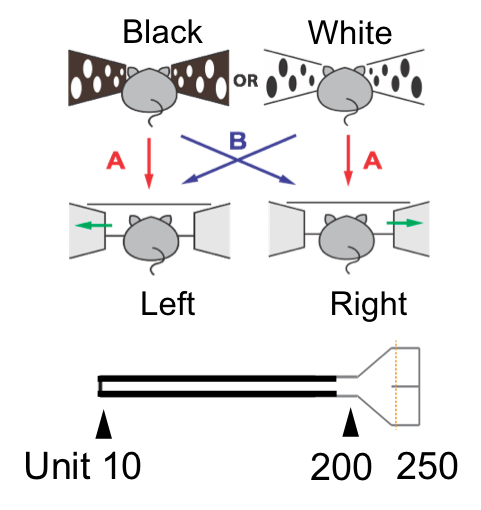


The data came from calcium imaging of mouse retrosplenial cortex (RSC) during a navigation-based decision-making task. The mouse ran down a virtual Y-maze and used visual cues on the wall to guide its choice into one of the two maze arms. The rewarded associations between cue and choice (rule A or rule B as indicated in the schematic) switched without explicit signaling in the middle of the session. We want to understand what variables drove neuron activity during the task.

The dataset consists of time series of variables (sampled at 6 Hz) organized in a Python dictionary. Use the following keys to get the values of variables: 
- `activity`: deconvolved calcium activity of 13 RSC neurons, as an array of # of timepoints x # of neurons. These values are all non-negative, and were already multiplied by 10 to be give an approximate spike count. (Typically, 1 spike ~= 0.1 deconvolved activity).
- `frame_trial_mem`: trial number of each time point, as a vector of # of timepoints
- `pos_F`: mouse's forward position in the maze ranging from 10 to 250 a.u., as a vector of # of timepoints. Unit 200 is the Y-intersection. Occasionally the mouse went backward so there are a few points with positions <10. Timepoints in inter-trial interval (ITI) are NaNs, which we will dispose of before fitting our models.
- `cue`, `cho`, `corr`, `prev_corr`: binary variables for the cue identity, the mouse's choice, the outcome of the current trial and one previous trial, as vectors of # of timepoints. Cue: white (1) vs. black (0); choice: right (1) vs. left (0); outcome and previous outcome: correct (1) vs. incorrect (0). In the given data, these variables are zero-centered, so instead of 1 or 0, the values are actually 0.5 or -0.5. 
- `pitch`, `roll`, `yaw`: the mouse's running velocities (a.u.) on the spherical treadmill, as vectors of # of timepoints

Download the data from https://drive.google.com/file/d/1VVmw9GqTpbHbeFmG-EmDFyldhSmly8Oo or https://drive.google.com/file/d/1JfgN6NMGK5xe41A4mCZWNNTFnaHdf84G/view?usp=sharing.

Run the cells below to load the data and print some data descriptors.

In [2]:
# Load dataset
with open(Path("data", "glm_data.pkl"), "rb") as file:
    data = pickle.load(file)

In [3]:
# Display all the variables
list(data.keys())

['offset',
 'cue',
 'cho',
 'corr',
 'pitch',
 'roll',
 'yaw',
 'activity',
 'frame_trial_mem',
 'prev_corr',
 'cho_frame_offsets',
 'pos_F']

In [4]:
# Check length of the time series and number of neurons
_n_timepoints = data["frame_trial_mem"].shape[0]
_n_neurons = data["activity"].shape[1]
_n_trials = np.unique(
    data["frame_trial_mem"][~np.isnan(data["frame_trial_mem"])]
).shape[0]

print(f"Number of the timepoints = {_n_timepoints}")
print(f"Number of neurons = {_n_neurons}")
print(f"Number of trials = {_n_trials}")

Number of the timepoints = 18687
Number of neurons = 13
Number of trials = 243


### Section 1.2: Visualizing data

**First 600 timepoints of data**

Let's first plot some variables for the first 600 timepoints (100 sec).

(18687, 13)


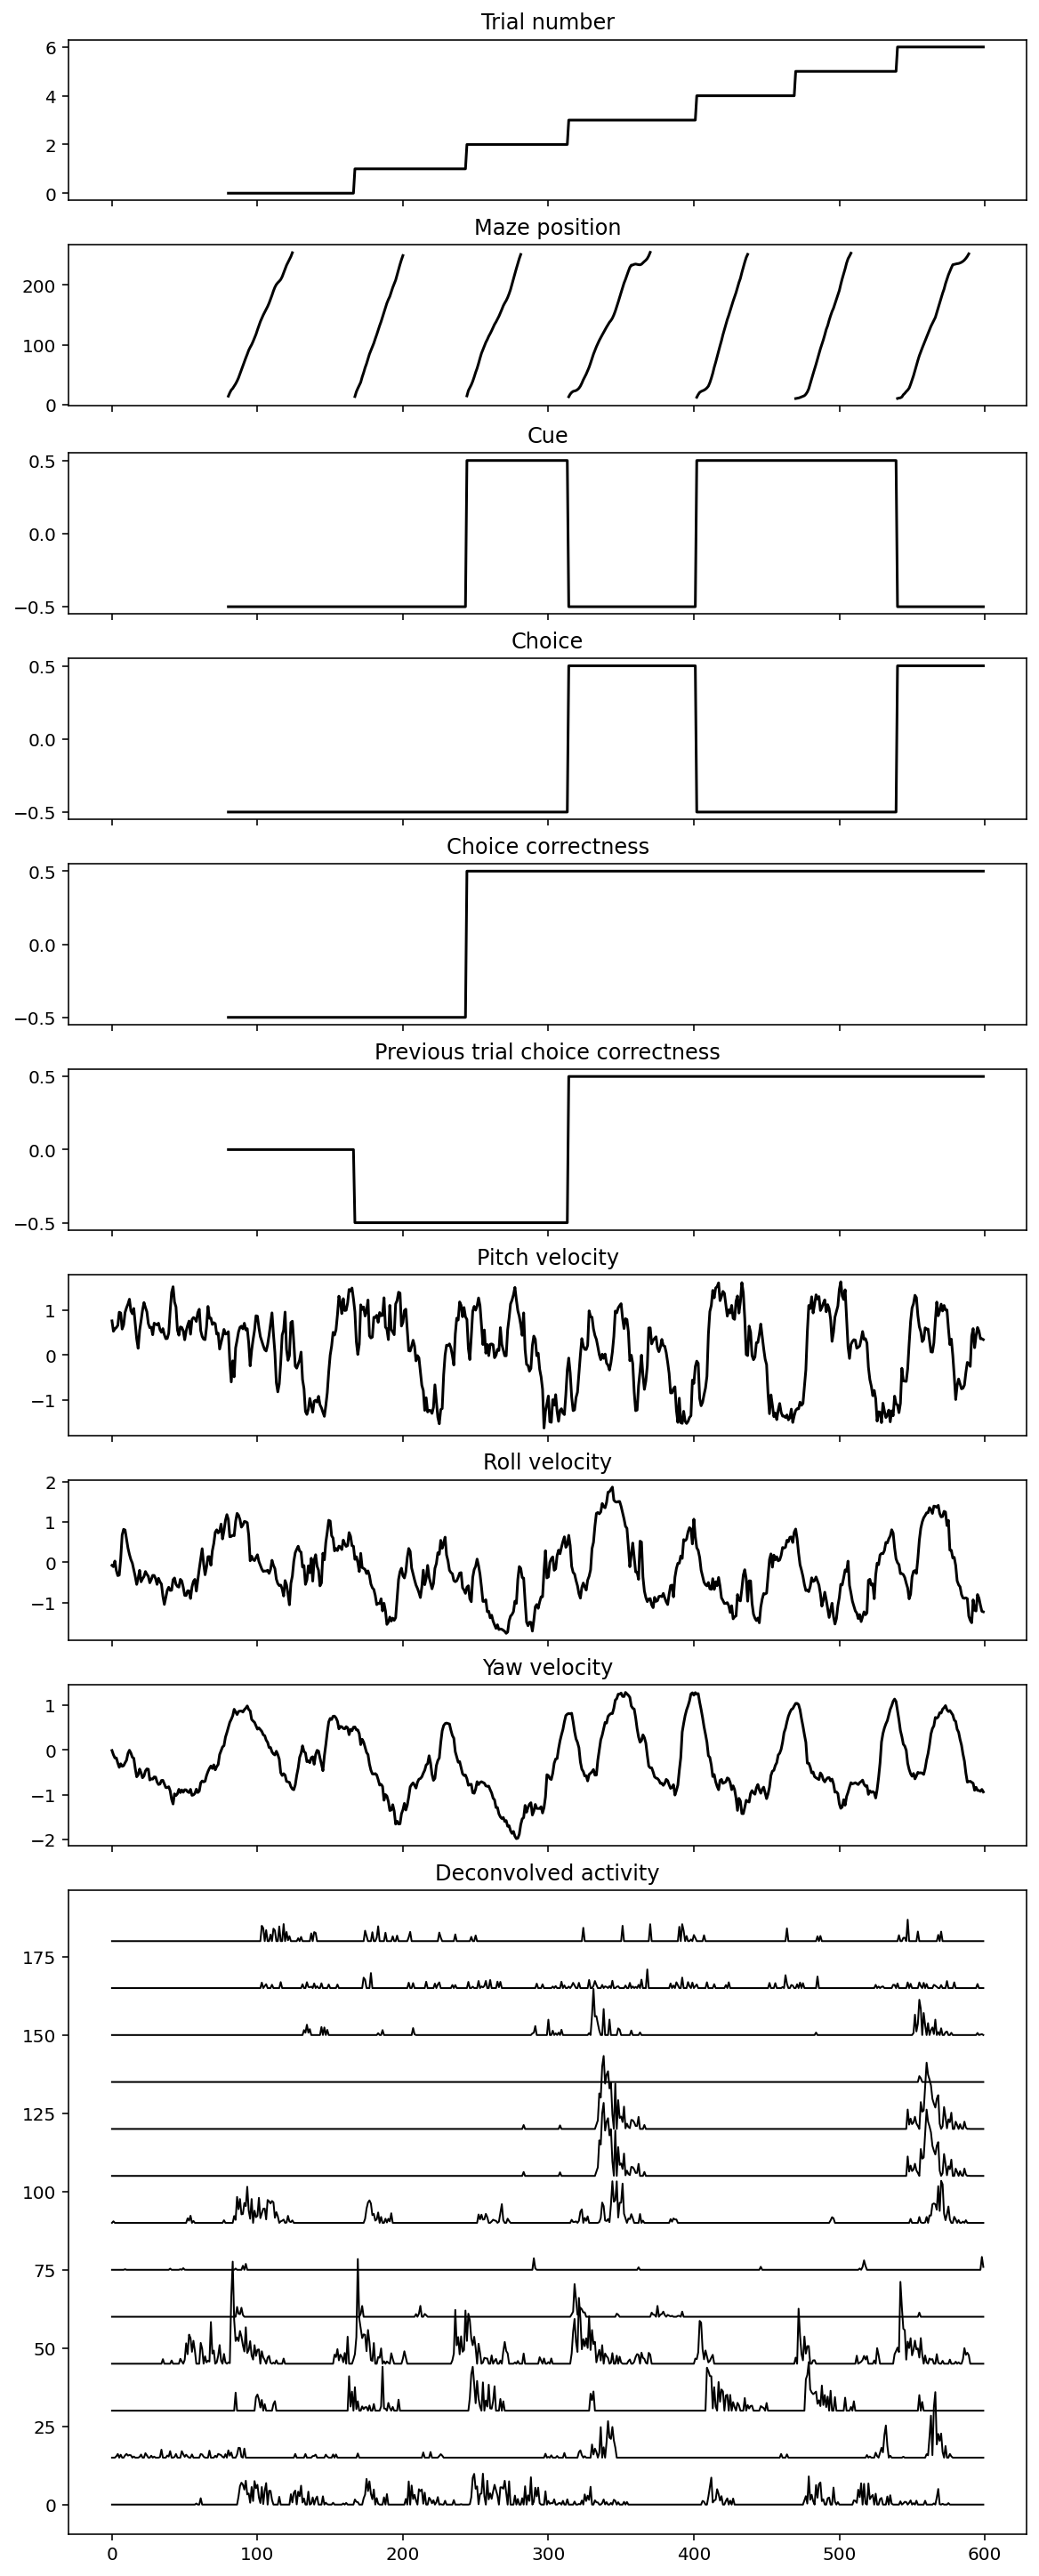

In [5]:
# Set time period of plotting
start_timepoint = 0
end_timepoint = 600

# Set up dictionary for pretty naming
variable_names = {
    "frame_trial_mem": "Trial number",
    "pos_F": "Maze position",
    "cue": "Cue",
    "cho": "Choice",
    "corr": "Choice correctness",
    "prev_corr": "Previous trial choice correctness",
    "pitch": "Pitch velocity",
    "roll": "Roll velocity",
    "yaw": "Yaw velocity",
}

# Set up plot
f, ax = plt.subplots(
    len(variable_names) + 1,
    1,
    sharex=True,
    figsize=(8, 20),
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1] * len(variable_names) + [4]},
)

# Loop over variables and create plot
for i, variable in enumerate(variable_names):
    ax[i].plot(data[variable][start_timepoint:end_timepoint], "k")
    ax[i].set_title(variable_names[variable])

# Different formatting for displaying the neuron activity, needs to be run separately from the loop above
ax[-1].plot(
    data["activity"][start_timepoint:end_timepoint] + 15 * np.arange(13),
    "k",
    linewidth=1,
)
ax[-1].set_title("Deconvolved activity")

print(data["activity"].shape)
plt.show()

**Average activity within each of the 4 trial types**

Let's look at cell 0's average activity vs maze position in the 4 trial types separately: black vs white cue and left vs right turn. Note that 'black-left' means that the cue was black and that the mouse actually turned left, regardless of if turning left was correct (rule A) or incorrect (rule B). We will discretize maze position into bins so we can get average neural activity for each bin.

You can use the slider to look at different neurons. Uncheck `view_binned_data` to see the un-binned scatter plot of deconvolved fluorescence versus maze position, or leave it checked to look at average activity at different maze position bins, with shading of ± 0.1 standard deviation. (The standard deviation across trials is very large, so ± 0.1 standard deviation is used so that the plot looks reasonable.)

In [6]:
@widgets.interact(
    i_neuron=widgets.IntSlider(min=0, max=data["activity"].shape[1] - 1),
    view_binned_data=widgets.Checkbox(value=True),
    ax=fixed(None),
)
def plot_trial_average_data(i_neuron, view_binned_data, ax):
    """Plot data for a specific neuron

    Args:
      i_neuron (int): which neuron to plot
      view_binned_data (bool): binary indicator of whether the data should be binned
                      into position bins
      ax: matplotlib axis

    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    # Set plotting parameters
    labels = {
        -0.5: {-0.5: "black-left", 0.5: "black-right"},
        0.5: {-0.5: "white-left", 0.5: "white-right"},
    }
    colors = {-0.5: {-0.5: "r", 0.5: "#ff8000"}, 0.5: {-0.5: "b", 0.5: "c"}}

    # We'll have overlapping bins (so the first will be 0 - 10, 5 - 15)
    bin_spacing = 5
    bin_half_width = 5
    maze_bin_centers = np.arange(bin_half_width, 255, bin_spacing)

    # Loop over two cue options
    for cue_value in [-0.5, 0.5]:

        # Loop over two turn options
        for turn_value in [-0.5, 0.5]:

            # Find time points with this combo of cue and turn
            cue_timepoints = data["cue"] == cue_value
            turn_timepoints = data["cho"] == turn_value
            timepoints = cue_timepoints & turn_timepoints
            activity = data["activity"][timepoints]
            maze_position = data["pos_F"][timepoints]

            if view_binned_data:

                # Set nan bins to a number we can ignore
                maze_position[np.isnan(maze_position)] = -100

                # Get activity mean and std based on position bin occupied
                activity_binned_mean = np.zeros(
                    (maze_bin_centers.shape[0], activity.shape[1])
                )
                activity_binned_std = np.zeros(
                    (maze_bin_centers.shape[0], activity.shape[1])
                )
                for i, bin_center in enumerate(maze_bin_centers):
                    bin_inds = (maze_position >= bin_center - bin_half_width) & (
                        maze_position < bin_center + bin_half_width
                    )
                    activity_binned_mean[i] = np.mean(activity[bin_inds], axis=0)
                    activity_binned_std[i] = np.std(activity[bin_inds], axis=0)

                # Visualize
                ax.plot(
                    maze_bin_centers,
                    activity_binned_mean[:, i_neuron],
                    label=labels[cue_value][turn_value],
                    c=colors[cue_value][turn_value],
                )
                ax.fill_between(
                    maze_bin_centers,
                    activity_binned_mean[:, i_neuron]
                    - 0.1 * activity_binned_std[:, i_neuron],
                    activity_binned_mean[:, i_neuron]
                    + 0.1 * activity_binned_std[:, i_neuron],
                    alpha=0.1,
                    color=colors[cue_value][turn_value],
                )

            else:

                ax.scatter(
                    maze_position,
                    activity[:, i_neuron],
                    label=labels[cue_value][turn_value],
                    c=colors[cue_value][turn_value],
                    s=3,
                )

    ax.set(xlabel="Maze position", ylabel="Average deconvolved fluorescence")
    ax.legend();

interactive(children=(IntSlider(value=0, description='i_neuron', max=12), Checkbox(value=True, description='vi…

The activity clearly depends on the trial type, but there is significant variability in activity patterns on different trials of the same type (which you can see also by turning off `view_binned_data`). We will use GLMs to explore which variables measured during individuals trial are most useful for explaining the responses in single trials.

## Section 2: Fitting a basic Poisson GLM 

First we will assume that the neurons' tuning to task and behavioral variables is independent of maze position. In other words, we will try to predict the neural response given all the variables other than maze position. 

### Section 2.1: Building a design matrix X and extract response y

We concatenate the task variables and velocities to create a design matrix. We will only use data points where the mouse was in the maze (by removing frames where `pos_F = NaN`, which are inter-trial interval timepoints). Before fitting, we z-score the predictors so regularization will work evenly for each variable. 

In [7]:
data["cue"].shape, data["cho"].shape, data["corr"].shape, data["prev_corr"].shape

((18687,), (18687,), (18687,), (18687,))

In [8]:
# Concatenate predictors, including frames where mouse wasn't in the maze (between trials).
task_variables = np.vstack(
    (data["cue"], data["cho"], data["corr"], data["prev_corr"])
).T
print(f"task variables shape: {task_variables.shape}")

velocity = np.vstack((data["pitch"], data["roll"], data["yaw"])).T
print(f"velocity shape: {velocity.shape}")

# Build design matrix.
predictors = np.concatenate((task_variables, velocity), axis=1)

# Select frames only during maze traversal.
X = predictors.copy()
valid_frames = ~np.isnan(data["pos_F"])
X = X[valid_frames, :]
assert np.sum(np.isnan(X)) == 0, "NaNs remain in data."

# Z-score predictors.
X = scipy.stats.zscore(X, axis=0)

# Select valid frames of activity of all neurons.
y = data["activity"][valid_frames, :]

# The size of the design matrix shows how many valid timepoints are included.
print(f"predictor and outcome shapes: {X.shape}, {y.shape}")
assert X.shape[0] == y.shape[0] == 10683, "Incorrect variable dimensions."
assert X.shape[1] == 7, "Incorrect number of predictor features"
assert y.shape[1] == 13, "Incorrect number of neurons"

task variables shape: (18687, 4)
velocity shape: (18687, 3)
predictor and outcome shapes: (10683, 7), (10683, 13)


### Section 2.2: Train-test split

We want to fit the model to only 85% of the given data, holding out 15% of trials to use for cross-validation. 

*Notice that we want to split at the **trial level** rather than at individual imaging frames (timepoints), such that the data points in the same trial will be partitioned into the train or test set as a group.* This is done to avoid having data of the same trial included in both the train and the test set. To split on the trial level, we make use of the variable `frame_trial_mem` and a sklearn class `GroupShuffleSplit`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html. You can get multiple splits using this class (for example for k-fold validation) but we only want 1. This gives us indices to split the data (but not the actual split data!)


In [9]:
# Set up split.
gss = model_selection.GroupShuffleSplit(n_splits=1, train_size=0.85, random_state=42)

# Get train and test frame indices (gss.split() is a generator so we use next)
train_frames, test_frames = next(
    gss.split(X, y, groups=data["frame_trial_mem"][valid_frames])
)

len(train_frames), len(test_frames)

(8979, 1704)

Let's make sure this worked and each trial is in either test or train, not split across both:

In [10]:
# Get trials associated with train vs test
test_trials = np.unique(data["frame_trial_mem"][valid_frames][test_frames])
train_trials = np.unique(data["frame_trial_mem"][valid_frames][train_frames])

# Ensure the intersection of these arrays is empty
assert np.intersect1d(test_trials, train_trials).shape == (0,)

We'll now make a function that combines the design matrix building and test/train splitting so we can use this later.

**TO-DO:** Complete the function `build_and_split_design_matrix` by splitting X and y data

In [11]:
def build_and_split_design_matrix(
    predictors: np.ndarray,
    train_frames: np.ndarray,
    test_frames: np.ndarray,
    valid_frames: np.ndarray,
    activity: np.ndarray,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Process design matrix by removing NaN frames, z-scoring, and splitting data

    Args:
       predictors (ndarray): array of shape (n_frames, n_predictors) with input data for encoding model
       train_frames (ndarray): array of shape (n_frames, ) containing indices
                   of training frames, should be based on valid (non-NaN) frames
       test_frames (ndarray): array of shape (n_frames, ) containing indices
                   of testing frames, should be based on valid (non-NaN) frames
       valid_frames (ndarray): array of shape (n_frames, ) containing boolean indicator of
                   whether frame is valid (non-NaN)
       activity (ndarray): array of sape (n_frames, n_neurons) containing neural activity

    Returns:
       ndarray: array of shape (n_test_frames, n_predictors) with test input data
       ndarray: array of shape (n_train_frames, n_predictors) with train input data
       ndarray: array of shape (n_test_frames, n_neurons) with test neural activity data
       ndarray: array of shape (n_train_frames, n_neurons) with train neural activity data
    """
    X = predictors.copy()

    # Select frames only during maze traversal (remove frames in ITI)
    X = X[valid_frames, :]

    # Ensure no NaNs remain
    assert np.sum(np.isnan(X)) == 0, "NaNs remain in data"

    # Z-score predictors
    X = scipy.stats.zscore(X, axis=0)

    # Select valid frames of activity of all neurons
    y = activity[valid_frames, :]

    # TO-DO: Split the data based on train and test frame indices
    X_test = X[test_frames, :]
    X_train = X[train_frames, :]
    y_test = y[test_frames, :]
    y_train = y[train_frames, :]

    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = build_and_split_design_matrix(
    predictors, train_frames, test_frames, valid_frames, data["activity"]
)

### Section 2.3: Fitting Poisson GLM 

We will fit a Poisson GLM to predict the neural response $y$ as:

$ log(y) = w_0 + w_1x_1 + w_2x_2 + ...$

where $x_1$, $x_2$, etc are our various features and $w_0$, $w_1$, etc are the weights to be learned.

Below, we set up the model. We specify `tol` and `max_iter` so the Poisson GLM has time to converge. 

**TO-DO:** Figure out what setting `alpha` to 0 and `fit_intercept` to True do based on the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html. Then complete the code to actually fit the model to data (again, consult the documentation). So far, we've included all neurons in `y_train` and `y_test` but we want to fit for just one neuron (neuron 0 for now) so you'll need to get the appropriate data. ✅

We then print the learned intercept ($w_0$ above) and coefficients ($w_1$, $w_2$, etc). If you used the test/train split generated above with random state equal to 42, the intercept should be -1.647. If not, double check your code.

In [13]:
# Set up model
model = PoissonRegressor(alpha=0.0, fit_intercept=True, tol=2e-4, max_iter=500)

# Fit model to data
i_neuron = 0
model.fit(X_train, y_train[:, i_neuron])

# Print the coefficients and intercept
print(f"intercept: {model.intercept_:0.4f}")
print(f"model coeficients: {[round(x, 4) for x in model.coef_]}")

intercept: -1.6475
model coeficients: [0.9669, -0.098, -0.2219, -0.3285, 0.3838, 0.005, 0.2159]


### Section 2.4: Evaluating model performance

We first want to assess if the model fits the training data well. 

**TO-DO:** With the fitted model parameters, we use the input variables to predict neural responses on trials in the training set by calling the `predict` method. Complete the code below to do this (check the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html) for PoissonRegressor if stuck). ✅

This is the simplest model we'll fit, so we'll use `_simple` to store the predictions etc.

In [14]:
def visualize_predictions(
    real_data: np.ndarray,
    fit1: np.ndarray,
    label1: str,
    fit2: Optional[np.ndarray] = None,
    label2: Optional[np.ndarray] = None,
) -> None:
    fig, ax = plt.subplots(figsize=(16, 2))
    ax.plot(real_data[:2000], "k", linewidth=0.5, label="Data")
    ax.plot(fit1[:2000], "r", label=label1)
    if fit2 is not None:
        ax.plot(fit2[:2000], "b", label=label2)
    plt.legend()
    plt.show()
    return None

In [15]:
def plot_deviance_comparisons(
    dev_train_simple: np.ndarray,
    dev_test_simple: np.ndarray,
    dev_train_CV: Optional[np.ndarray] = None,
    dev_test_CV: Optional[np.ndarray] = None,
    dev_train_basis: Optional[np.ndarray] = None,
    dev_test_basis: Optional[np.ndarray] = None,
    dev_train_history: Optional[np.ndarray] = None,
    dev_test_history: Optional[np.ndarray] = None,
    dev_train_coupling: Optional[np.ndarray] = None,
    dev_test_coupling: Optional[np.ndarray] = None,
) -> None:
    train_devs = (
        [dev_train_simple]
        + [dev_train_CV]
        + [dev_train_basis]
        + [dev_train_history]
        + [dev_train_coupling]
    )
    test_devs = (
        [dev_test_simple]
        + [dev_test_CV]
        + [dev_test_basis]
        + [dev_test_history]
        + [dev_test_coupling]
    )

    # Remove none values
    if None in train_devs:
        train_devs = train_devs[: train_devs.index(None)]
        test_devs = test_devs[: test_devs.index(None)]

    colors = ["#649fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
    labels = ["Simple", "CV", "Basis", "History", "Coupling"]

    current_colors = colors[: len(train_devs)]
    current_labels = labels[: len(train_devs)]
    current_x = np.arange(0, len(train_devs))

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

    rects1 = axes[0].bar(current_x, train_devs, color=current_colors)
    axes[0].set(
        title="Train Data",
        ylabel="Fraction of Devianced Explained",
        xticks=current_x,
        xticklabels=current_labels,
    )

    rects2 = axes[1].bar(current_x, test_devs, color=current_colors)
    axes[1].set(title="Test Data", xticks=current_x, xticklabels=current_labels)

    def autolabel(rects: BarContainer, ax: plt.Axes) -> None:
        """Attach a text label above each bar displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2.0,
                1.01 * height,
                s=f"{height:.3f}",
                ha="center",
                va="bottom",
            )
        return None

    autolabel(rects1, axes[0])
    autolabel(rects2, axes[1])

    plt.show()
    return None

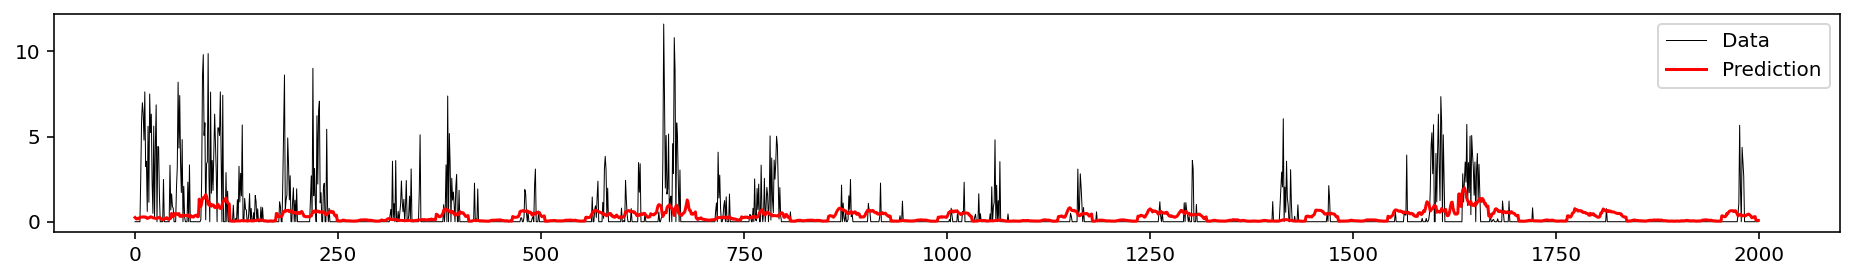

In [16]:
# Make prediction
y_pred_train_simple = model.predict(X_train)

# Display the first 2000 timepoints
visualize_predictions(y_train[:, i_neuron], y_pred_train_simple, "Prediction")


To evaluate the performance of the Poisson GLM, we use *fraction deviance explained*, analogous the fraction variance explained, or $R^2$ for ordinary linear model.

$\text{fraction deviance explained} = 1 - \frac{\text{model deviance}}{\text{null deviance}}$

The deviance compares the log-likelihood of a (virtual) model that captures all variability in the data to log-likelihood of the actual model fits. The fraction deviance explained compares the model deviance to that of a null model that assumes the same (average) prediction for each time point. For more information see: https://en.wikipedia.org/wiki/Deviance_(statistics).

Luckily, the Poisson regressor class has a method `score` that computes the fraction of deviance explained.

In [17]:
# Calculate fraction deviance explained on training set
dev_train_simple = model.score(X_train, y_train[:, i_neuron])

print(f"Frac. training set deviance explained = {dev_train_simple:0.3f}")

Frac. training set deviance explained = 0.224


**TO-DO:** 
Get the predictions on the test data and evaluate the fraction deviance explained on the test set. 

In [18]:
# Make prediction
y_pred_test_simple = model.predict(X_test)

# Calculate fraction deviance explained on test set
dev_test_simple = model.score(X_test, y_test[:, i_neuron])
print(f"Frac. test set deviance explained = {dev_test_simple:0.3f}")

Frac. test set deviance explained = 0.174


Let's look at at the test predictions:

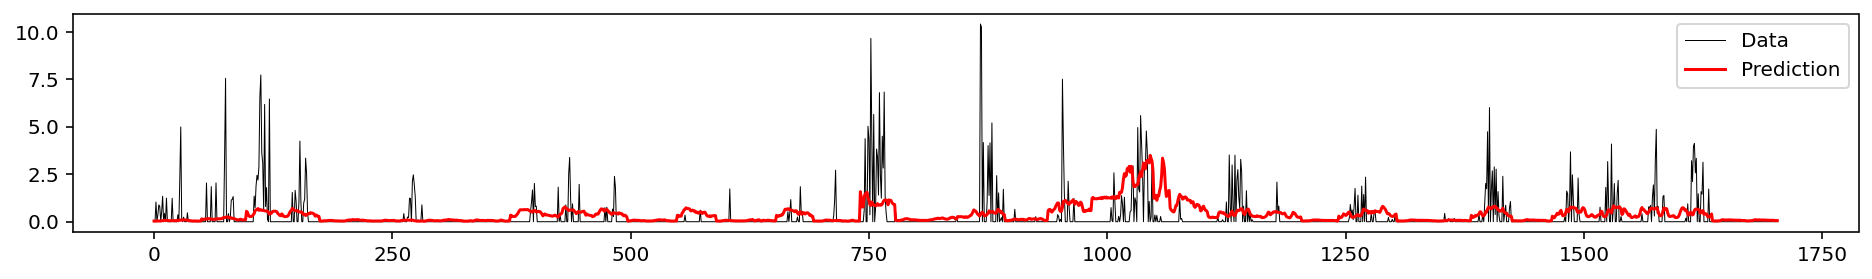

In [19]:
visualize_predictions(y_test[:, i_neuron], y_pred_test_simple, "Prediction")

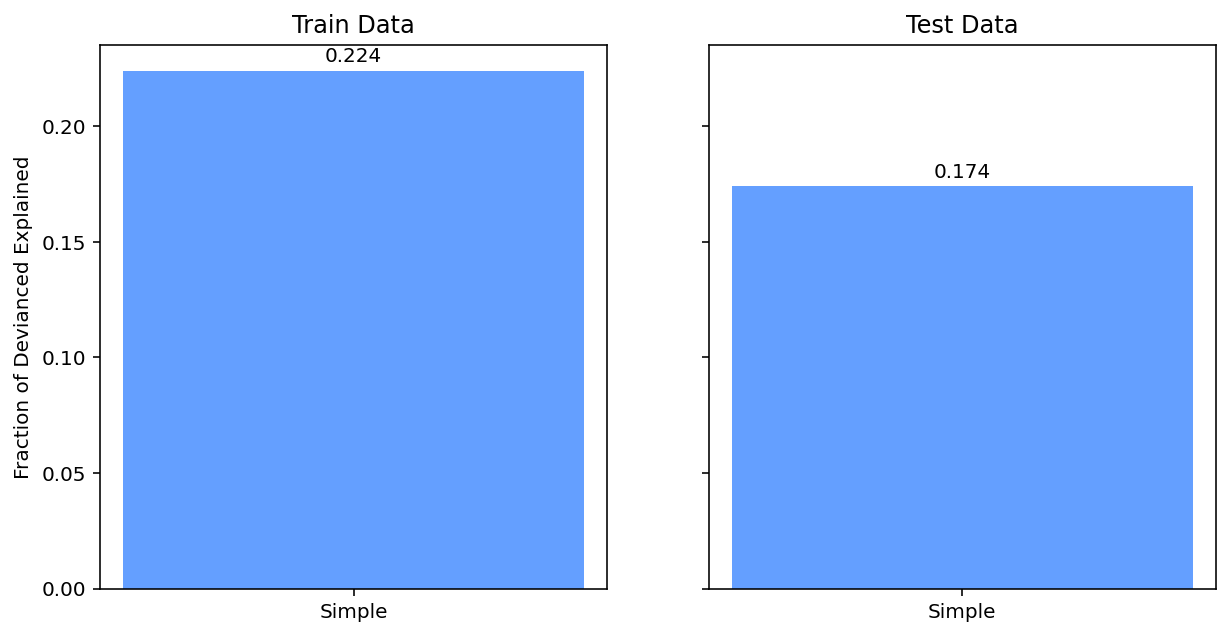

In [20]:
plot_deviance_comparisons(dev_train_simple, dev_test_simple)

**TO-DO:** In your write up, discuss: ✅

* Qualitatively, do you think that this model predicts the neural recordings well, with the chosen design matrix and model assumptions? What are some things we could try to improve the model?

The model fits better than randomly guessing or always predicting the global average spike rate, but there is substantial room for improvement. 
One improvement would be to include the spike rates from previous time points so that the model would account for refractory periods and other known phenomena of a neuron's behavior based on its recent past.
Also, including the spike rates of the other neurons for this neuron's predictions could increase accuracy by sharing patterns learned by the other neurons like.

* How do you interpret the model's performance on the training versus test sets? Does it appear to be overfitting to the training data? How could we address overfitting, if it is occurring?

There is some slight over-fitting because the fraction of deviance explained is greater on the training data than the test data.
That said, there is visually some correlation between the observed and predicted spike rates in the test data indicating that the model is identifying some real patterns.

## Section 3: Adding regularization with cross-validation



<hr style="height:1pt">

It is a common practice to perform regularization on the model when the predictors contain correlated variables. We normally use L2 regularization to provide numerical stability in the presence of correlated variables, and L1 regularization to obtain sparse weights, forcing the model to select a minimal set of features that can explain the data. Elastic net combines both L1 and L2 regularization. Unfortunately, the Poisson Regressor class in sklearn only allows L2 regularization so we will focus on this. Please note though that researchers would typically use L1 in addition, or ElasticNet. Hopefully, this will be added soon to sklearn!

To fit a regularized Poisson GLM, we can change the argument alpha - this controls the weight of L2 regularization. To find the optimal strength for the regularization, we perform cross validation (CV) on a range of different regularization strengths and select the one that gives us the best model performance on CV held-out data. 


We will be using k-fold cross-validation, described well on Wikipedia (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Sklearn has an extremely useful class `GridSearchCV` which allows to search over different values of a parameter (in this case regularization strength) based on cross-validation. It then refits the best model using all of the data.

Notice that for splitting of the CV folds, we again want to split at the **trial level** instead of individual frames to make sure that all data points in the same trial would be partitioned into either train or held-out set. We can do this by using the `GroupKFold` class in sklearn. This functions similarly to the `GroupShuffleSplit` class we used earlier for the train-test split, but is designed specifically for k-folds cross-validation.

We will search over 5 values of alpha: 0, 0.001, 0.01, 0.1, and 1. This is not very comprehensive - in research you may want to do a bigger search. In this case, we do not want the homework to be too time intensive to run so we will limit ourselves to these 5 values.

In [21]:
# Set up parameters to search over
parameters = {"alpha": [0, 0.001, 0.01, 0.1, 1]}

# Create K Fold CV splitter
cv_splitter = GroupKFold(n_splits=5).split(
    X_train, y_train, groups=data["frame_trial_mem"][valid_frames][train_frames]
)

# Set up grid search and run it on our data
model_CV = GridSearchCV(
    PoissonRegressor(fit_intercept=True, tol=2e-4, max_iter=500),
    parameters,
    refit=True,
    cv=cv_splitter,
)

model_CV.fit(X_train, y_train[:, i_neuron])

print(f"The best model is {model_CV.best_estimator_}")

The best model is PoissonRegressor(alpha=0.01, max_iter=500, tol=0.0002)


We should see that the best alpha value is 0.01 based on this cross validation. We can also see more details of the cross-validation:

In [22]:
model_CV.cv_results_

{'mean_fit_time': array([0.01819887, 0.01088734, 0.01057286, 0.00845718, 0.00773797]),
 'std_fit_time': array([5.71162695e-03, 8.37474022e-04, 7.07036499e-04, 1.97998556e-04,
        9.45543677e-05]),
 'mean_score_time': array([0.00057101, 0.00035691, 0.00032167, 0.0003232 , 0.00034108]),
 'std_score_time': array([1.91659534e-04, 1.56188737e-05, 5.75256158e-06, 1.26461673e-05,
        3.17587866e-05]),
 'param_alpha': masked_array(data=[0, 0.001, 0.01, 0.1, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0},
  {'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1}],
 'split0_test_score': array([0.24156607, 0.24155855, 0.24111855, 0.22373918, 0.10545524]),
 'split1_test_score': array([0.20702079, 0.20725828, 0.20860014, 0.19366295, 0.08878876]),
 'split2_test_score': array([0.19894892, 0.19908171, 0.19961696, 0.18554092, 0.08704004]),
 'split3_test_score': array([0.13539073, 0.13548198, 

Let's plot the fraction of deviance explained vs regularization strength.

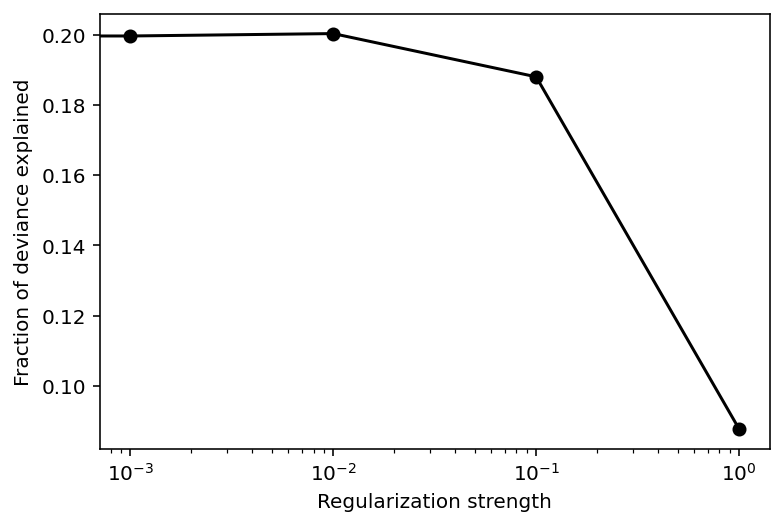

In [23]:
# Consolidate scores from different folds
scores = np.zeros((len(parameters["alpha"])))
for i_split in range(model_CV.n_splits_):
    scores += model_CV.cv_results_[f"split{i_split}_test_score"]
scores /= model_CV.n_splits_

fig, ax = plt.subplots()

ax.plot(parameters["alpha"], scores, "-ok")
ax.set(xlabel="Regularization strength", ylabel="Fraction of deviance explained")
ax.set(xscale="log");

Let's compute the fraction of deviance of our best regularized model and visualize the predictions on test data. We'll use a helper function `plot_deviance_comparisons` to compare to the simple model.

**TO-DO:** Compute the fraction deviance explained for the best model, as picked by cross-validation. ✅

Frac. train set deviance explained = 0.223
Frac. test set deviance explained = 0.179


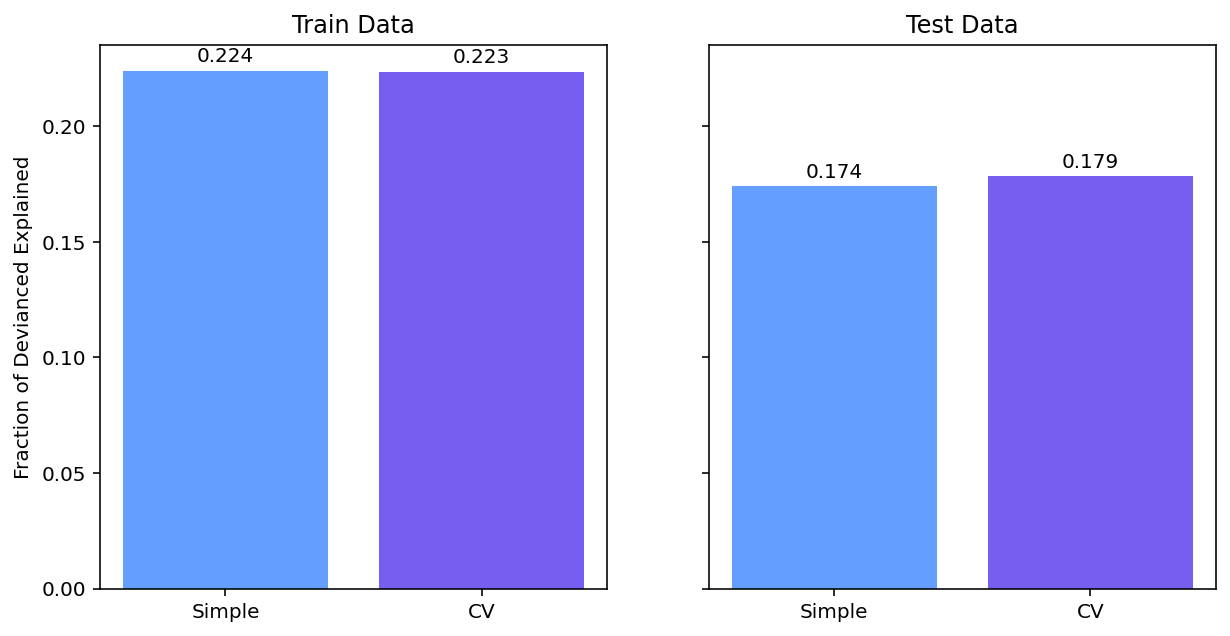

In [24]:
# Calculate fraction deviance explained on training set
dev_train_CV = model_CV.score(X_train, y_train[:, i_neuron])
print(f"Frac. train set deviance explained = {dev_train_CV:.3f}")

# Calculate fraction deviance explained on test set
dev_test_CV = model_CV.score(X_test, y_test[:, i_neuron])
print(f"Frac. test set deviance explained = {dev_test_CV:.3f}")

# Visualize
plot_deviance_comparisons(dev_train_simple, dev_test_simple, dev_train_CV, dev_test_CV)

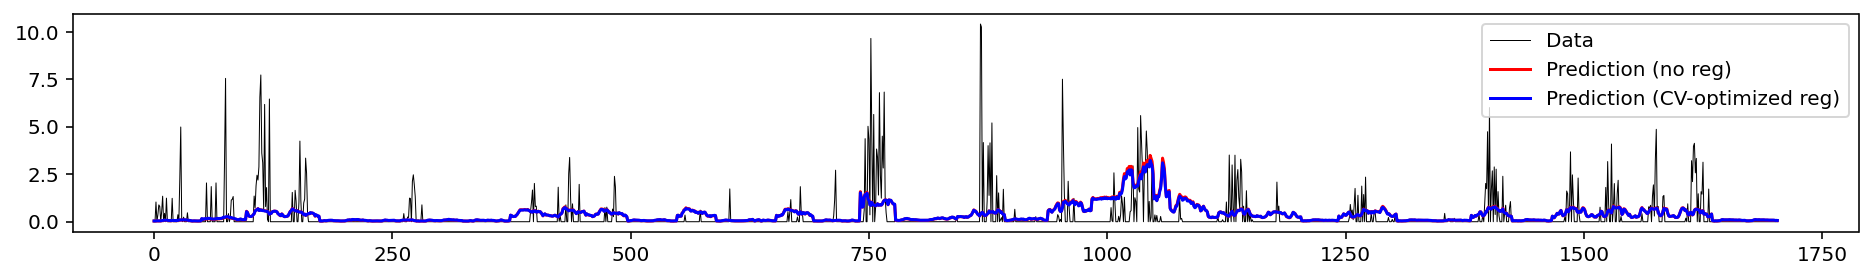

In [25]:
# Compute predictions
y_pred_train_CV = model_CV.predict(X_train)
y_pred_test_CV = model_CV.predict(X_test)

visualize_predictions(
    y_test[:, i_neuron],
    y_pred_test_simple,
    "Prediction (no reg)",
    y_pred_test_CV,
    "Prediction (CV-optimized reg)",
)

**TO-DO:** In your write-up, discuss the following: ✅

* Did regularization help the model fit the training data better? Why or why not? 

Marginally because the amount of regularization was minimal.

* Did it help fit the test data better? Why or why not? (Hint: The training fit quality and the test fit quality only changed by small amounts with regularization, but both were guaranteed to change in the direction they changed. Try to think about why.)

The regularization improved the $D^2$ of the model on both the training and test data, but helped the model more on predictions on the test data than on the training data. The improvement on the training data is slight and could be due to stochastic differences during fitting. The improvement on the test data is larger (though still small) and was likely attributable to the regularization reducing over-fitting of the model. The provided "Hint" says that regularization was guaranteed to improve the $D^2$ for both the training and test data, but this does not hold for higher values for $\alpha$. Therefore, I don't think this is outcome was determined by the formulae for $D^2$ or the structure of the model, but instead due to the heuristic that a bit of regularization often improves model performance.

## Section 4: Basis expansion

<hr style="height:1pt">

So far, we have fit models that explain the data with a fraction of explained deviance of about 20%. Let's see if we can get better! To improve the model performance, we want to perform some "feature engineering" using our knowledge about the neurons tuning. It is known (or at least observed) that in the context of spatial navigation, RSC neurons show location-specific tuning to different task variables, i.e. their response to task variables (such as the cue) can be present/strong in one spatial location but absent/weak in another. To express the tuning as a function of spatial location, we want to create a set of **position basis functions** (similar to "place fields") that tile the full length of the maze. We then use these to construct new features (task features * position basis functions) and add them to our design matrix. This allows the model to have different parameters for the influence of each task variable at different parts of the maze.

A common selection of the position basis function is **raised cosine bumps** with the general form:

$$f_i(x) =
  \begin{cases}
    \frac{1}{2} \cos( ax  - \varphi_i ) + \frac{1}{2}       & \quad \text{if } \varphi_i - \pi < ax \leq \varphi_i + \pi\\
    0  & \quad \text{otherwise } 
  \end{cases}
$$

where $\varphi_i$ is the center location of the $i^{th}$ bump, and $a$ is a scaling factor that controls the width of the bump.

We have implemented the function `eval_cosine_bump` to build the basis functions.

In [ ]:
def create_cosine_bumps(x, centers, widths):
    """Create raised cosine bumps

    Args:
        x (ndarray): x positions to evaluate the cosine bumps on
        centers (ndarray): contains center positions of bumps, should be
                   shape (number of bumps, )
        widths (ndarray): the width of each bump, should be same shape as centers

    Returns:
        ndarray: basis functions, shape (len(x), number of bumps)
    """
    assert (
        centers.shape == widths.shape
    ), "Centers and widths should have same number of elements"

    x_reshape = x.reshape(
        -1,
    )

    # Create empty array for basis functions
    bases = np.full((x.shape[0], centers.shape[0]), np.NaN)

    # Loop over center positions
    for idx, cent in enumerate(centers):
        bases[:, idx] = (
            np.cos(2 * np.pi * (x_reshape - cent) / widths[idx]) * 0.5 + 0.5
        ) * (np.absolute(x_reshape - cent) < widths[idx] / 2)

    return bases

### Section 4.1: Create basis functions

Let's try to create 10 basis functions that tile the maze (from start position = 10 to end position = 250). 

Notice that the width-to-spacing ratio is set at 4:1, which is a commonly used empirical value that adjacent bases are spaced by $\frac{\pi}{2}$. To tile the space, the minimal ratio required is 2:1, but one can increase this number to create "denser" basis set.

In [ ]:
## Create basis functions

# Set parameters
start_pos = 10
end_pos = 250
n_pos_bases = 10

# Linearly space the centers of the position bases
pos_centers = np.linspace(start_pos, end_pos, n_pos_bases)

# Set width of the position bases as 4 times spacing
pos_width = 4 * scipy.stats.mode(np.diff(pos_centers))[0][0]

# Evaluate the values of the position series on each base
positions = np.linspace(start_pos, end_pos, 1000)
pos_bases = create_cosine_bumps(
    positions, pos_centers, pos_width * np.ones_like(pos_centers)
)

# Visualize
fig, ax = plt.subplots()
ax.plot(positions, pos_bases)
ax.set(xlabel="Maze position");

### Section 4.2: Evalute the real position at the basis functions

Here we evalute the values of real time series of the maze position at each basis function. From now on, it's a good practice to establish a good naming system for expanded predictors so that we can keep track of their identities easily. Here we use `fPos_bump#` to denote each basis, with # being the number of that basis. You will see how this becomes handy later when we want to exact coefficients of a specific group of expanded predictors.

In [ ]:
## Apply position basis functions to forward maze position

# Evaluate the basis expanded forward position at each basis
f_pos_bases = create_cosine_bumps(
    data["pos_F"], pos_centers, pos_width * np.ones_like(pos_centers)
)
f_pos_names = [f"fPos_bump{i}" for i in range(len(pos_centers))]

# Visualize for the first 600 timepoints
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
axes[0].plot(data["pos_F"][:600], "k")
axes[0].set(title="Maze position")

axes[1].plot(f_pos_bases[:600, :])
axes[1].set(title="Expanded position");

In [ ]:
# Check the names and dimension of the expanded positions
print("Names =", f_pos_names, "\nShape of expanded positions =", f_pos_bases.shape)

### Section 4.3: Fit GLM with  position basis functions applied to task variables

Now we can apply the task variables onto these expanded position predictors by taking the **product** of the time series of the expanded position and the selected variables (i.e. creating interaction terms of task variables and position bases). We want to apply the basis expansion for these variables: `cue`, `cho`, `corr`, `prev_corr`. Here we append the basis name (`fPos_bump#`) to the end of the task variables for each interaction to keep track of predictor names. The expanded position predictors are included in the expanded predictors too, which can be interpreted as task variable-invariant position tuning.

In [ ]:
# Apply forward position bases to selected variables
var_names = ["cue", "cho", "corr", "prev_corr"]

# Initialize features and names with expanded positions
n_bases = f_pos_bases.shape[1]
expanded_features = np.full(
    (f_pos_bases.shape[0], n_bases * (len(var_names) + 1)), np.NaN
)
expanded_features[:, : f_pos_bases.shape[1]] = f_pos_bases.copy()
expanded_feature_names = f_pos_names.copy()

# Multiply individual variables with expanded position predictors
for i, name in enumerate(var_names):

    expanded_features[:, (i + 1) * n_bases : (i + 2) * n_bases] = (
        data[name][:, None] * f_pos_bases
    )
    expanded_feature_names += [f"{name}*{base_name}" for base_name in f_pos_names]

print(expanded_features.shape)

Now we can visualize the expanded cue:

In [ ]:
## Plot expanded cue

# Use the name list to identify the range of the indices
start_idx = expanded_feature_names.index("cue*fPos_bump0")
end_idx = expanded_feature_names.index("cue*fPos_bump{}".format(n_pos_bases - 1))

fig, axes = plt.subplots(2, 1, figsize=(20, 6))
axes[0].plot(data["cue"][:600], "k")
axes[0].set(title="Cue")

axes[1].plot(expanded_features[:600, start_idx : end_idx + 1])
axes[1].set(title="Expanded cue");

Now we will include these expanded features in our design matrix and fit a new Poisson GLM that incorporates them!

**TO-DO:** Complete the function `fit_and_evaluate_model` below. This will take in the predictors and should build and split the design matrix (as in sections 2.1/2.2), fit the model using cross-validation over different regularization strengthes, and return train and test predictions and fraction of deviance explained values.

(Most of the time it's safer to sub-select frames after basis expansion. In the next part when we incorporate activity history of neurons as predictors, we want to perform temporal basis expansion on the complete continuous time series of activity before sub-selecting data for fitting.)

In [ ]:
def fit_and_evaluate_model(
    i_neuron,
    predictors,
    train_frames,
    test_frames,
    valid_frames,
    frame_trial_mem,
    activity,
    alpha_list,
):
    """Fit and evaluate Poisson GLM model on predictors input data, including searching over regularization strength

    Args:
       i_neuron (int): which neuron to fit GLMs for
       predictors (ndarray): array of shape (n_frames, n_predictors) with input data for encoding model
       train_frames (ndarray): array of shape (n_frames, ) containing indices
                   of training frames, should be based on valid (non-NaN) frames
       test_frames (ndarray): array of shape (n_frames, ) containing indices
                   of testing frames, should be based on valid (non-NaN) frames
       valid_frames (ndarray): array of shape (n_frames, ) containing boolean indicator of
               whether frame is valid (non-NaN)
       frame_trial_mem (ndarray): trial number of each frame
       activity (ndarray): array of sape (n_frames, n_neurons) containing neural activity
       alpha_list (list): list of possible regularization strengthes to search over

    Returns:
       object: sklearn object representing model
       float: fraction of explained variance on training data
       float: fraction of explained variance on test data
       ndarray: array of shape (n_train_frames,) with predicted neural activity on train data
       ndarray: array of shape (n_test_frames,) with predicted neural activity on test data

    """
    # Step 1) Build design matrix
    # Step 2) Split design matrix
    # (hint: maybe a function we already created will help with the above?)
    ...

    # Step 3) Fit cross-validated model (as in Section 3). Grid search over alpha_list values
    # Set up parameters to search over
    ...

    # Step 4) Compute fraction of devianced explained on training and test sets
    ...

    # Step 5) Get model predictions
    ...

    return model, dev_train, dev_test, y_pred_train, y_pred_test


# Incorporate expanded features and velocity signals into design matrix
predictors = np.concatenate((expanded_features, velocity), axis=1)
predictor_names = expanded_feature_names.copy() + ["pitch", "roll", "yaw"]

i_neuron = 0
alpha_list = [0, 0.001, 0.01, 0.1, 1]
outs = fit_and_evaluate_model(
    i_neuron,
    predictors,
    train_frames,
    test_frames,
    valid_frames,
    data["frame_trial_mem"],
    data["activity"],
    alpha_list,
)
(
    model_basis,
    dev_train_basis,
    dev_test_basis,
    y_pred_train_basis,
    y_pred_test_basis,
) = outs

In [ ]:
# Visualize fraction of deviance explained
plot_deviance_comparisons(
    dev_train_simple,
    dev_test_simple,
    dev_train_CV,
    dev_test_CV,
    dev_train_basis,
    dev_test_basis,
)

In [ ]:
# Visualize predictions of this model versus predictions of previous model
visualize_predictions(
    y_test[:, i_neuron],
    y_pred_test_CV,
    "Prediction (Reg)",
    y_pred_test_basis,
    "Prediction (Basis)",
)

### Section 4.4: Visualize tuning functions (kernels)

We can visualize the fitted tuning function, or kernel, by multiplying the coefficient of each expanded feature with the position bases and summing them up. Note that these are the linear kernels, before the activation function is applied. To get the *gain* (as plotted in Pillow et al. (2008)), you need to exponentiate these kernels.

In [ ]:
# Identify indices for position bases
start_idx = predictor_names.index("fPos_bump0")
end_idx = predictor_names.index("fPos_bump{}".format(n_pos_bases - 1))

# Grab corresponding coefficients
coef = model_basis.best_estimator_.coef_[start_idx : end_idx + 1]

# Reconstruct tuning function
tuning = np.sum((pos_bases * coef), axis=1)

fig, ax = plt.subplots()
ax.plot(positions, tuning, "k")
ax.set(xlabel="Maze position");

Visualize the tuning functions for task variables: `cue`, `cho`, `corr`, `prev_corr`. 

In [ ]:
var_names = ["cue", "cho", "corr", "prev_corr"]  #'position'
variable_names["position"] = "Position alone"

fig, ax = plt.subplots()
for name in var_names:

    # Identify indices for position bases
    if name == "position":
        start_idx = predictor_names.index("fPos_bump0")
        end_idx = predictor_names.index("fPos_bump{}".format(n_pos_bases - 1))
    else:
        start_idx = predictor_names.index("{}*fPos_bump0".format(name))
        end_idx = predictor_names.index("{}*fPos_bump{}".format(name, n_pos_bases - 1))

    # Grab corresponding coefficient
    coef = model_basis.best_estimator_.coef_[start_idx : end_idx + 1]

    # Reconstruct tuning function
    tuning = np.sum((pos_bases * coef), axis=1)

    ax.plot(positions, tuning, label=variable_names[name])

plt.legend(bbox_to_anchor=(1.02, 1))
ax.set(xlabel="Maze position", title="Kernels for all expanded variables");

### Section 4.5: All neurons

In the cell below, you can choose the neuron to look at. We then plot the average activity within each of the 4 trial types, fit the Poisson GLM , and plot the kernels. Be patient when choosing a new neuron as it will take a few moments to fit the model.

For some neurons, you will get "Convergence warnings". Ignore these for the purposes of this exercise (we'd need to try fitting for more iterations to see if it could converge, but that would take too long)

In [ ]:
# @markdown Execute to enable demo
@widgets.interact(
    neuron=widgets.IntSlider(min=0, max=data["activity"].shape[1] - 1),
)
def visualize_fits(neuron):
    print(f"Neuron {neuron}")
    # Fit model
    outs = fit_and_evaluate_model(
        neuron,
        predictors,
        train_frames,
        test_frames,
        valid_frames,
        data["frame_trial_mem"],
        data["activity"],
        alpha_list,
    )
    model_temp, _, _, _, _ = outs

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_trial_average_data(neuron, view_binned_data=True, ax=axes[0])

    for name in var_names:

        # Identify indices for position bases
        if name == "position":
            start_idx = predictor_names.index("fPos_bump0")
            end_idx = predictor_names.index("fPos_bump{}".format(n_pos_bases - 1))
        else:
            start_idx = predictor_names.index("{}*fPos_bump0".format(name))
            end_idx = predictor_names.index(
                "{}*fPos_bump{}".format(name, n_pos_bases - 1)
            )

        # Grab corresponding coefficient
        coef = model_temp.best_estimator_.coef_[start_idx : end_idx + 1]

        # Reconstruct tuning function
        tuning = np.sum((pos_bases * coef), axis=1)

        axes[1].plot(positions, tuning, label=variable_names[name])

    plt.legend(bbox_to_anchor=(1.02, 1))
    axes[1].set(xlabel="Maze position", title="Kernels for all expanded variables");

**TO-DO:** In your write-up, discuss the following:

* Compare the kernels to the **average activity witin each of the 4 trial types** section.
Do the kernels we obtained from GLM make sense? What do the kernels tell you that the average activity doesn't?

**OPTIONAL TO-DO:**

(1) Try to increase or reduce the number of position bases. How does the performance change?

(2) What would happen if you change the width-to-spacing ratio of the basis functions to 1? (no fitting required)

In [ ]:
#### Your code here #### (Optional)

## Section 5: Activity history

<hr style="height:1pt">

Sometimes, we want to consider how the activity of a neuron in the past affects its current activity. We can do this by creating temporal shifts of the neuron's activity as predictors, in the direction that the past activity is used to predict current activity. We can expand the activity with temporal kernels that allow **time dilation**, i.e. finer temporal structures near the current time and coarser temporal dependency for data points far away in time. 

Here is a particular example:

In [ ]:
# Set up paramters for temporal basis functions
# the spacings between the centers and the widths increase logarithmically to allow time dilation
fs = 6  # sampling rate
n_tm_bases = 6
tm_centers = np.logspace(0, 1, n_tm_bases)
tm_widths = np.logspace(0, 1, n_tm_bases)
tm_bases = np.arange(
    -18, 19, 0.1
)  # symmetric around zero, so when we do the convolution, t=0 is at the center

# Set up temporal basis functions
tm_filts = create_cosine_bumps(tm_bases, tm_centers, tm_widths)

# Normalize so the area under each basis is 1
tm_filts = tm_filts / np.sum(tm_filts, axis=0)

fig, ax = plt.subplots()
ax.plot(tm_bases / fs, tm_filts)
ax.set(xlabel="Time (sec)");

Notice that the temporal kernels extend forward in time, which brings past activity into future timepoints. In other words, to get past activity to be incorporated into a predictor at time `t`, the activity around time `t-tau` needs to be "smeared" forward in time by `tau`.

To apply the temporal kernels to the neuron's activity, we convolve (`np.convolve`) the time series of activity with individual temporal kernels. We also keep track of the expanded variable names by appending `*tm_bump#` to the cell name.

In [ ]:
def apply_temporal_kernels(i_neuron, tm_filts, activity):
    """

    Args:
      i_neuron (int): which neuron to apply temporal kernels to
      tm_filts (ndarray): array of shape (n_filter_frames, n_filters) containing temporal filters
      activity (ndarray): array of shape (n_frames, n_neurons) containing neural activity

    Returns:
      ndarray: array of shape (n_frames, n_filters) containing filtered neural activity
      cell_names: list of length n_filters containing name of that predictor (neuron and filter number)
      this_Y: array of shape (n_frames, ) containing z-scored neural activity
    """
    # Grab and zscore this neuron's activity
    this_Y = scipy.stats.zscore(activity[:, i_neuron])

    # Initialize storage
    convolved_activity = np.full((this_Y.shape[0], tm_filts.shape[1]), np.NaN)
    cell_names = []

    for i_filt in range(tm_filts.shape[1]):

        # Convolve the activity with this filter
        convolved_activity[:, i_filt] = np.convolve(this_Y, tm_filts[:, i_filt], "same")

        # Append expanded name to the name list
        cell_names += [f"cell{i_neuron}*tm_bump{i_filt}"]

    return convolved_activity, cell_names, this_Y

We can visualize the filtered activities (from timepoint 100 to 600).

In [ ]:
convolved_activity, cell_names, this_Y = apply_temporal_kernels(
    i_neuron, tm_filts, data["activity"]
)

fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 5]})
axes[0].plot(np.arange(100, 600) / fs, this_Y[100:600], "k")
axes[0].set(xlabel="Time (sec)", ylabel="Activity", title="Original activity")

axes[1].plot(
    np.arange(100, 600) / fs,
    convolved_activity[100:600, :] - np.arange(10, (n_tm_bases + 1) * 10, 10) + 60,
    "k",
)
axes[1].set(xlabel="Time (sec)", ylabel="Activity", title="Convolved activity");

**TO-DO:** Incoporate the convolved activity into the design matrix, fit a new Poisson GLM model, and get the predicted traces and fraction of deviance explained scores. Call the model **model_history**, the predictions **y_pred_test(train)_history**, and the scores **dev_test(train)_history**

Hint: We've made a function that does a lot of this!

In [ ]:
predictors = ...
predictor_names = ...

### your code here!

In [ ]:
# Visualize fraction of deviance explained
plot_deviance_comparisons(
    dev_train_simple,
    dev_test_simple,
    dev_train_CV,
    dev_test_CV,
    dev_train_basis,
    dev_test_basis,
    dev_train_history,
    dev_test_history,
)

# Visualize predictions of this model versus predictions of previous model
visualize_predictions(
    y_test[:, i_neuron],
    y_pred_test_basis,
    "Prediction (Basis)",
    y_pred_test_history,
    "Prediction (History)",
)

Let's visualize the temporal tuning curve

In [ ]:
# Visualize the temporal tuning function
start_idx = predictor_names.index("cell{}*tm_bump0".format(i_neuron))
end_idx = predictor_names.index("cell{}*tm_bump{}".format(i_neuron, n_tm_bases - 1))
coef = model_history.best_estimator_.coef_[start_idx : end_idx + 1]

fig, ax = plt.subplots()
ax.plot(tm_bases / fs, np.sum((tm_filts * coef), axis=1), "k")
ax.set(xlabel="Time (sec)");

**TO-DO:** In your write-up, discuss the following:

* Describe the temporal tuning function. What does this tell you that you couldn't have known from the average tuning functions at the start of this exercise?

## Section 6: Coupling

<hr style="height:1pt">

Lastly, we want to invetigate the effect of the activity of other neurons in the population. By the same token, we can use the same temporal kernels to create temporal shifts of other neurons' activity and incorporate them as predictors.

Below, we create temporally expanded and shifted copies of the activity of other 11 neurons and keep track of the names.



In [ ]:
## Temporally expand all neurons' activity

## Note that we'll expand activity of all neurons, including the one we want to fit,\
# so the previous "activity history"  predictors will get automatically re-created and included.

# Grab number of all cells
n_cells = data["activity"].shape[1]

# Initialize the matrix for temporally expanded activity, dim = # of frames by (# of cells x # of temporal filters)
convolved_activity_coupling = np.full(
    (data["activity"].shape[0], n_cells * tm_filts.shape[1]), np.NaN
)
cell_names = []

# Loop over cells
for i_cell in range(n_cells):

    these_activities, these_names, _ = apply_temporal_kernels(
        i_cell, tm_filts, data["activity"]
    )
    convolved_activity_coupling[
        :, (i_cell * tm_filts.shape[1]) : ((i_cell + 1) * tm_filts.shape[1])
    ] = these_activities
    cell_names += these_names

**TO-DO:** Incoporate the coupling activity into the design matrix, fit a new Poisson GLM model, and get the predicted traces and fraction of deviance explained scores. Call the model **model_coupling**, the predictions **y_pred_test(train)_coupling**, and the scores **dev_test(train)_coupling**

Hint: We've made a function that does a lot of this!

In [ ]:
# your code here!

In [ ]:
# Visualize fraction of deviance explained scores
plot_deviance_comparisons(
    dev_train_simple,
    dev_test_simple,
    dev_train_CV,
    dev_test_CV,
    dev_train_basis,
    dev_test_basis,
    dev_train_history,
    dev_test_history,
    dev_train_coupling,
    dev_test_coupling,
)

# Visualize predictions of this model versus predictions of previous model
visualize_predictions(
    y_test[:, i_neuron],
    y_pred_test_history,
    "Prediction (History)",
    y_pred_test_coupling,
    "Prediction (Coupling)",
)

In [ ]:
# Plot temporal kernels for all cells
fig, axes = plt.subplots(5, 3, figsize=(10, 10))
axes = axes.flatten()
for i_cell in range(n_cells):
    start_idx = predictor_names.index("cell{}*tm_bump0".format(i_cell))
    end_idx = predictor_names.index("cell{}*tm_bump{}".format(i_cell, n_tm_bases - 1))
    coef = model_coupling.best_estimator_.coef_[start_idx : end_idx + 1]

    axes[i_cell].plot(tm_bases / fs, np.sum((tm_filts * coef), axis=1), "k")
    axes[i_cell].set(xlabel="Time (sec)", title=f"Cell #{i_cell}")

plt.tight_layout()

**TO-DO:** In your write-up, discuss:

*  Describe the coupling profiles between neurons. What does this tell you that you couldn't have known from the average tuning functions at the start of this exercise?
*  How did your fraction deviance explained change for training and testing sets? What do you conclude from observing those changes?


## Section 7: All neurons

<hr style="height:1pt">

Here we compile everything so we can fit all models and visualize all plots for all neurons! The tuning curves pictured are all using the full model with coupling.

Be patient when you move the slider as fitting all the models for each neuron will take a few minutes!

In [ ]:
# @markdown Execute to enable demo
@widgets.interact(
    i_neuron=widgets.IntSlider(min=0, max=data["activity"].shape[1] - 1),
)
def fit_all_models_per_neuron(i_neuron):
    print(f"Neuron {i_neuron}")

    alpha_list = [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]

    # Simple model without regularization
    print("...Fitting simple model without regularization...")
    task_variables = np.vstack(
        (data["cue"], data["cho"], data["corr"], data["prev_corr"])
    ).T
    velocity = np.vstack((data["pitch"], data["roll"], data["yaw"])).T
    predictors = np.concatenate((task_variables, velocity), axis=1)

    outs = fit_and_evaluate_model(
        i_neuron,
        predictors,
        train_frames,
        test_frames,
        valid_frames,
        data["frame_trial_mem"],
        data["activity"],
        [0],
    )
    (
        model_simple,
        dev_train_simple,
        dev_test_simple,
        y_pred_train_simple,
        y_pred_test_simple,
    ) = outs

    # CV regularized model
    print("...Fitting CV model with regularization...")
    outs = fit_and_evaluate_model(
        i_neuron,
        predictors,
        train_frames,
        test_frames,
        valid_frames,
        data["frame_trial_mem"],
        data["activity"],
        alpha_list,
    )
    model_CV, dev_train_CV, dev_test_CV, y_pred_train_CV, y_pred_test_CV = outs

    # Model with basis expansion
    print("...Fitting model with basis expansion...")
    predictors = np.concatenate((expanded_features, velocity), axis=1)
    predictor_names = expanded_feature_names.copy() + ["pitch", "roll", "yaw"]

    outs = fit_and_evaluate_model(
        i_neuron,
        predictors,
        train_frames,
        test_frames,
        valid_frames,
        data["frame_trial_mem"],
        data["activity"],
        alpha_list,
    )
    (
        model_basis,
        dev_train_basis,
        dev_test_basis,
        y_pred_train_basis,
        y_pred_test_basis,
    ) = outs

    # Model with prior history
    print("...Fitting model with prior activity history...")
    convolved_activity = convolved_activity_coupling[
        :, (i_neuron * tm_filts.shape[1]) : ((i_neuron + 1) * tm_filts.shape[1])
    ]
    predictors = np.concatenate(
        (expanded_features, velocity, convolved_activity), axis=1
    )
    predictor_names = (
        expanded_feature_names.copy() + ["pitch", "roll", "yaw"] + cell_names
    )

    outs = fit_and_evaluate_model(
        i_neuron,
        predictors,
        train_frames,
        test_frames,
        valid_frames,
        data["frame_trial_mem"],
        data["activity"],
        alpha_list,
    )
    (
        model_history,
        dev_train_history,
        dev_test_history,
        y_pred_train_history,
        y_pred_test_history,
    ) = outs

    # Coupling model
    print("...Fitting model with all of the above and coupling")

    predictors = np.concatenate(
        (expanded_features, velocity, convolved_activity_coupling), axis=1
    )
    predictor_names = (
        expanded_feature_names.copy() + ["pitch", "roll", "yaw"] + cell_names
    )

    outs = fit_and_evaluate_model(
        i_neuron,
        predictors,
        train_frames,
        test_frames,
        valid_frames,
        data["frame_trial_mem"],
        data["activity"],
        alpha_list,
    )
    (
        model_coupling,
        dev_train_coupling,
        dev_test_coupling,
        y_pred_train_coupling,
        y_pred_test_coupling,
    ) = outs

    # Visualize results
    # Visualize fraction of deviance explained scores
    plot_deviance_comparisons(
        dev_train_simple,
        dev_test_simple,
        dev_train_CV,
        dev_test_CV,
        dev_train_basis,
        dev_test_basis,
        dev_train_history,
        dev_test_history,
        dev_train_coupling,
        dev_test_coupling,
    )

    # Visualize predictions of this model versus predictions of previous model
    visualize_predictions(
        y_test[:, i_neuron],
        y_pred_test_history,
        "Prediction (History)",
        y_pred_test_coupling,
        "Prediction (Coupling)",
    )

    # Visualize tuning curves
    var_names = ["cue", "cho", "corr", "prev_corr"]  #'position'
    variable_names["position"] = "Position alone"

    fig, ax = plt.subplots()
    for name in var_names:

        # Identify indices for position bases
        if name == "position":
            start_idx = predictor_names.index("fPos_bump0")
            end_idx = predictor_names.index("fPos_bump{}".format(n_pos_bases - 1))
        else:
            start_idx = predictor_names.index("{}*fPos_bump0".format(name))
            end_idx = predictor_names.index(
                "{}*fPos_bump{}".format(name, n_pos_bases - 1)
            )

        # Grab corresponding coefficient
        coef = model_basis.best_estimator_.coef_[start_idx : end_idx + 1]

        # Reconstruct tuning function
        tuning = np.sum((pos_bases * coef), axis=1)

        ax.plot(positions, tuning, label=variable_names[name])

    plt.legend(bbox_to_anchor=(1.02, 1))
    ax.set(xlabel="Maze position", title="Kernels for all expanded variables")

    # Plot temporal kernels for all cells
    fig, axes = plt.subplots(5, 3, figsize=(10, 10))
    axes = axes.flatten()
    for i_cell in range(n_cells):
        start_idx = predictor_names.index("cell{}*tm_bump0".format(i_cell))
        end_idx = predictor_names.index(
            "cell{}*tm_bump{}".format(i_cell, n_tm_bases - 1)
        )
        coef = model_coupling.best_estimator_.coef_[start_idx : end_idx + 1]

        axes[i_cell].plot(tm_bases / fs, np.sum((tm_filts * coef), axis=1), "k")
        axes[i_cell].set(xlabel="Time (sec)", title=f"Cell #{i_cell}")

    plt.tight_layout()

**TO-DO:** In your write-up discuss:


*  How does the best regularization strength tend to change for more complex models? Why does that make sense?
*  You added many different features to the design matrix over the course of this exercise. Which ones had the largest effect on model performance for different neurons? What do you conclude about the neural encoding properties?

